In [1]:
%matplotlib inline
import sys
# include the path where 
sys.path.append('/Users/pradap/Documents/Research/Python-Package/anhaid/py_entitymatching/')

In [2]:
# py_entitymatching relies on the following packages from the Python eco-system

|S.No|  Package | Comments  |
|---|---|---|
|1|  *pandas*  | provides data structures (such as DataFrame) to <span style="color:red;">store and manage relational data</span>. Specifically, DataFrame is used to represent input tables.  |
|2| *scikit-learn*   | provides implementations for common <span style="color:red;">machine learning</span> algorithms. Specifically, this is used in ML-based matchers.  |
|3| *joblib*  | provides <span style="color:red;">multiprocessing</span> capabilities. Specifically, this is used to parallelize blockers across multiple processors.|
|4| *PyQt4*  | provides tools to <span style="color:red;">build GUI</span>. Specifically, this is used to build GUI for labeling data  and debugging matchers.|
|5|  *py_stringsimjoin* |  provides <span style="color:red;">scalable</span> implementations for <span style="color:red;">string similarity joins</span> over two tables. Specifically,   this is used to scale blockers. |
|6| *py_stringmatching* | provides a comprehensive set of <span style="color:red;"> tokenizers and string similarity functions</span>. Specifically, this is to create features for blocking and matching.|
|7|  *cloudpickle* |provides functions to <span style="color:red;"> serialize Python constructs</span>. Specifically, this is used to load/save objects from/to disk. |
|8| *pyprind*  | library to display <span style="color:red;"> progress indicators</span>. Specifically, this is used to display progress of blocking functions, matching functions, etc.  |
|9| *pyparsing*  | library to <span style="color:red;">parse strings</span>. Specifically, this is used to parse rules/features that are declaratively written by the user.  |
|10|  *six* |  provides functions to <span style="color:red;">write compatible code across Python 2 and 3</span>. |

In [3]:
import py_entitymatching as em
import profiler
import pandas as pd

/Users/pradap/miniconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Read input tables

In [4]:
## Read input tables
A = em.read_csv_metadata('dblp_demo.csv', key='id')
B = em.read_csv_metadata('acm_demo.csv', key='id')

In [5]:
len(A), len(B), len(A) * len(B)

(1800, 1813, 3263400)

In [6]:
A.head(2)

,id,title,authors,venue,paper year
0,l0,Paradise: A Database System for GIS Applications,Paradise Team,SIGMOD Conference,1995
1,l1,A Query Language and Optimization Techniques for Unstructured Data,"Gerd G. Hillebrand, Peter Buneman, Susan B. Davidson, Dan Suciu",SIGMOD Conference,1996


In [7]:
B.head(2)

,id,title,authors,venue,paper year
0,r0,An efficient bitmap encoding scheme for selection queries,"Chee-Yong Chan, Yannis E. Ioannidis",International Conference on Management of Data,1999
1,r1,Integrating a Structured-Text Retrieval System with an Object-Oriented Database System,"Tak W. Yan, Jurgen Annevelink",Very Large Data Bases,1994


In [8]:
# If the tables are large we can downsample the tables like this
A1, B1 = em.down_sample(A, B, 500, 1, show_progress=False)
len(A1), len(B1)

# But for the demo, we will use the entire table A and B

(479, 500)

## Block tables to get candidate set

Number of unique values: 10
Number of missing values: 0

Unique values:
[1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003]

Frequency plot:



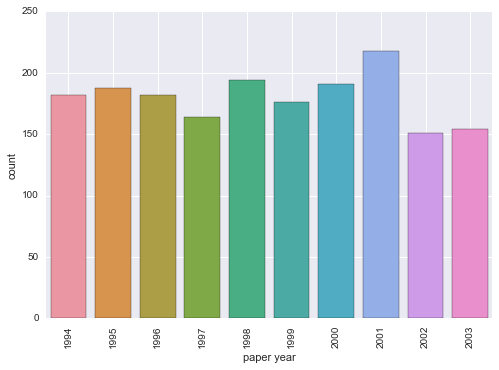

In [10]:
profiler.profile_table(A, 'paper year')

Number of unique values: 11
Number of missing values: 0

Unique values:
[1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 20003]

Frequency plot:



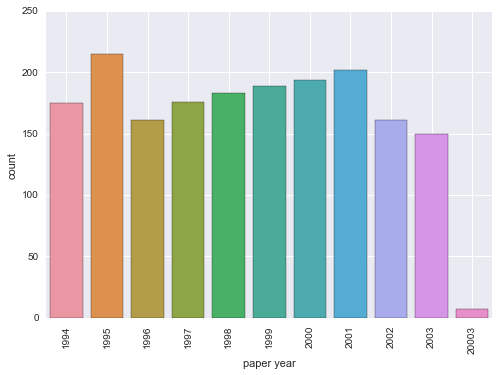

In [11]:
profiler.profile_table(B, 'paper year')

In [12]:
B.replace({'paper year':{
            20003:2003
        }}, inplace=True)

In [ ]:
### Blocking plan

### A, B -- AttrEquivalence blocker [year]--------------------------| Candidate set

In [13]:
# Create attribute equivalence blocker
ab = em.AttrEquivalenceBlocker()
# Block tables using 'year' attribute : same year include in candidate set
C1 = ab.block_tables(A, B, 'paper year', 'paper year', 
                     l_output_attrs=['title', 'authors', 'paper year'],
                     r_output_attrs=['title', 'authors', 'year']
                    )
len(C1)

AssertionError: Left output attributes are not in the left table

In [ ]:
C1.head(2)

### Debug blocking output

In [ ]:
# check whether the current blocking method has dropped a lot of potential matches
dbg = em.debug_blocker(C1, A, B)

In [ ]:
dbg.head()

In [ ]:
# em.view_table(dbg)

In [ ]:
# Revised blocking plan

# A, B -- AttrEquivalence blocker [year] --------------------|
#                                                           |---> candidate set
# A, B -- Overlap blocker [title]---------------------------|

In [ ]:
profiler.profile_table(A, 'title', plot=False)

In [ ]:
profiler.profile_table(B, 'title', plot=False)

In [ ]:
# Initialize overlap blocker
ob = em.OverlapBlocker()
# Block over title attribute
C2 = ob.block_tables(A, B, 'title', 'title', show_progress=False, overlap_size=1)
len(C2)

In [ ]:
# Combine the outputs from attr. equivalence blocker and overlap blocker
C = em.combine_blocker_outputs_via_union([C1, C2])
len(C)

In [ ]:
# Check again to see if we are dropping any potential matches
dbg = em.debug_blocker(C, A, B)


In [ ]:
dbg.head()

### Match tuple pairs in candidate set

#### 1. Sample candidate set  --> S
#### 2. Label S 
#### 3. Split S into development set (I) and evaluation set (J)
#### 4. Select best learning-based matcher X, using I
#### 5. Compute accuracy of X on J

In [ ]:
# Sample  candidate set
S = em.sample_table(C, 450)

In [ ]:
# Label S
S = em.label_table(S, 'label')

In [ ]:
# Load the pre-labeled data
S = em.read_csv_metadata('labeled_data_demo.csv', 
                         key='_id',
                         ltable=A, rtable=B, 
                         fk_ltable='ltable_id', fk_rtable='rtable_id')
len(S)

In [ ]:
# Split S into I an J
IJ = em.split_train_test(S, train_proportion=0.7, random_state=0)
I = IJ['train']
J = IJ['test']

### Selecting the best learning-based matcher using I


#### 1. Create a set of ML-matchers
#### 2. Generate a set of features (F)
#### 3. Convert I into a set of feature vectors (H) using F
#### 4. Select best learning-based matcher (X) using k-fold cross validation over H
#### 5. Debug X (and repeat the above steps)

In [ ]:
# Create a set of ML-matchers
dt = em.DTMatcher(name='DecisionTree', random_state=0)
svm = em.SVMMatcher(name='SVM', random_state=0)
rf = em.RFMatcher(name='RF', random_state=0)
lg = em.LogRegMatcher(name='LogReg', random_state=0)
ln = em.LinRegMatcher(name='LinReg')

In [ ]:
# Generate a set of features
F = em.get_features_for_matching(A, B)

In [ ]:
# List the feature names generated
F['feature_name']

In [ ]:
# Convert the I into a set of feature vectors using F
H = em.extract_feature_vecs(I, 
                            feature_table=F, 
                            attrs_after='label',
                            show_progress=False) 

In [ ]:
# Select the best ML matcher using CV
result = em.select_matcher([dt, rf, svm, ln, lg], table=H, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'label'],
        k=5,
        target_attr='label', metric='f1', random_state=0)
result['cv_stats']

#### Debug X (Random Forest)

In [ ]:
# Split H into P and Q
PQ = em.split_train_test(H, train_proportion=0.5, random_state=0)
P = PQ['train']
Q = PQ['test']

In [ ]:
# Debug RF matcher using GUI
em.vis_debug_rf(rf, P, Q, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'label'],
        target_attr='label')

In [ ]:
# Add a feature to do Jaccard on title + authors and add it to F

# Create a feature declaratively
sim = em.get_sim_funs_for_matching()
tok = em.get_tokenizers_for_matching()
feature_string = """jaccard(wspace((ltuple['title'] + ' ' + ltuple['authors']).lower()), 
                            wspace((rtuple['title'] + ' ' + rtuple['authors']).lower()))"""
feature = em.get_feature_fn(feature_string, sim, tok)

# Add feature to F
em.add_feature(F, 'jac_ws_title_authors', feature)

In [ ]:
# Print supported sim. functions
pd.DataFrame({'simfunctions':sorted(sim.keys())})

In [ ]:
# Print supported tokenizers
pd.DataFrame({'tokenizers':sorted(tok.keys())})

In [ ]:
F['feature_name']

In [ ]:
# Convert I into feature vectors using updated F
H = em.extract_feature_vecs(I, 
                            feature_table=F, 
                            attrs_after='label',
                            show_progress=False) 

In [ ]:
# Check whether the updated F improves X (Random Forest)
result = em.select_matcher([rf], table=H, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'label'],
        k=5,
        target_attr='label', metric='f1', random_state=0)
result['cv_stats']

In [ ]:
# Select the best matcher again using CV
result = em.select_matcher([dt, rf, svm, ln, lg], table=H, 
        exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'label'],
        k=5,
        target_attr='label', metric='f1', random_state=0)
result['cv_stats']

### Compute accuracy of X (Decision Tree) on J

#### 1. Train X using  H
#### 2. Convert J into a set of feature vectors (L)
#### 3. Predict on L using X
#### 4. Evaluate the predictions

In [ ]:
# Train using feature vectors from I 
dt.fit(table=H, 
       exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'label'], 
       target_attr='label')

# Convert J into a set of feature vectors using F
L = em.extract_feature_vecs(J, feature_table=F,
                            attrs_after='label', show_progress=False)

# Predict on L 
predictions = dt.predict(table=L, exclude_attrs=['_id', 'ltable_id', 'rtable_id', 'label'], 
              append=True, target_attr='predicted', inplace=False)

In [ ]:
# Evaluate the predictions
eval_result = em.eval_matches(predictions, 'label', 'predicted')
em.print_eval_summary(eval_result)